In [1]:
import os
import torch
import tifffile
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
images_path = "/kaggle/input/dataset/data/images"
labels_path = "/kaggle/input/dataset/data/labels"

In [4]:
valid_names = [f"{i}" for i in range(306)]


In [5]:
images = []
labels = []

for name in valid_names:
    img_path = os.path.join(images_path, name + ".tif")
    label_path = os.path.join(labels_path, name + ".png")
    img = tifffile.imread(img_path)
    img = np.transpose(img, (2, 0, 1))
    img = img / img.max()
    img = torch.tensor(img, dtype=torch.float32)
    images.append(img)

    label_path = os.path.join(labels_path, label_path)
    label = Image.open(label_path).convert("L")
    label = np.array(label)                        
    label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
    labels.append(label)

In [6]:
images_ten = torch.stack(images)
labels_ten = torch.stack(labels)

print("Image shape:", images_ten.shape)  
print("Label shape:", labels_ten.shape)  

print("Images type:", type(images_ten))  
print("Labels type:", type(labels_ten))  

Image shape: torch.Size([306, 12, 128, 128])
Label shape: torch.Size([306, 1, 128, 128])
Images type: <class 'torch.Tensor'>
Labels type: <class 'torch.Tensor'>


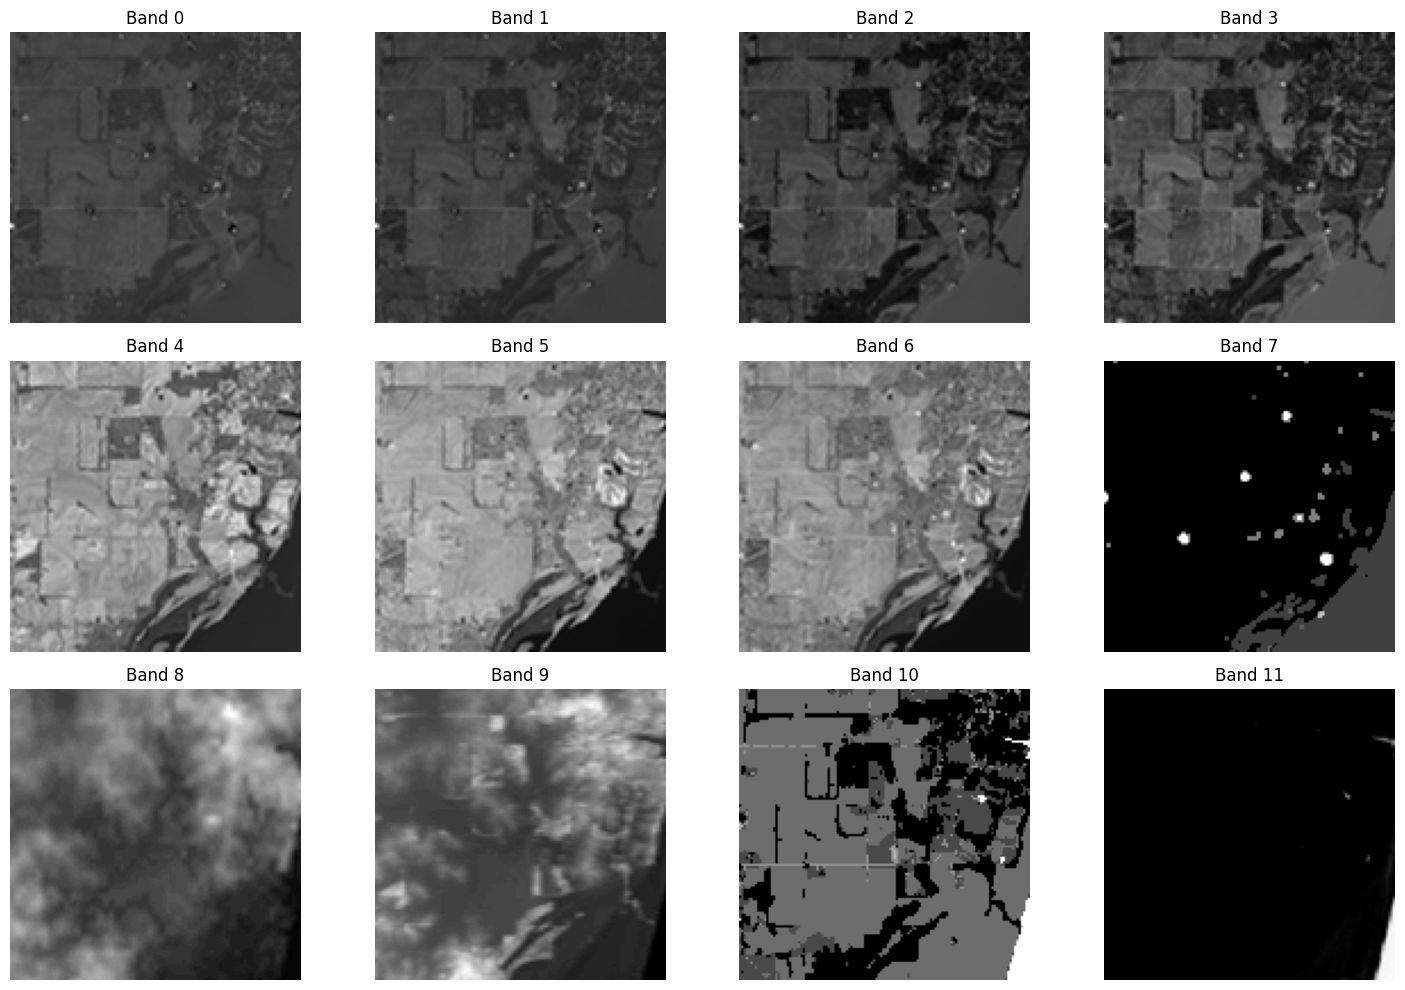

In [7]:
first_image = images_ten[8]

fig, axes = plt.subplots(3, 4, figsize=(15, 10))

for i in range(12):
    ax = axes[i // 4, i % 4]
    
    band = first_image[i]
    ax.imshow(band.numpy(), cmap='gray')
    ax.set_title(f"Band {i}")
    ax.axis('off')

plt.tight_layout()
plt.show()


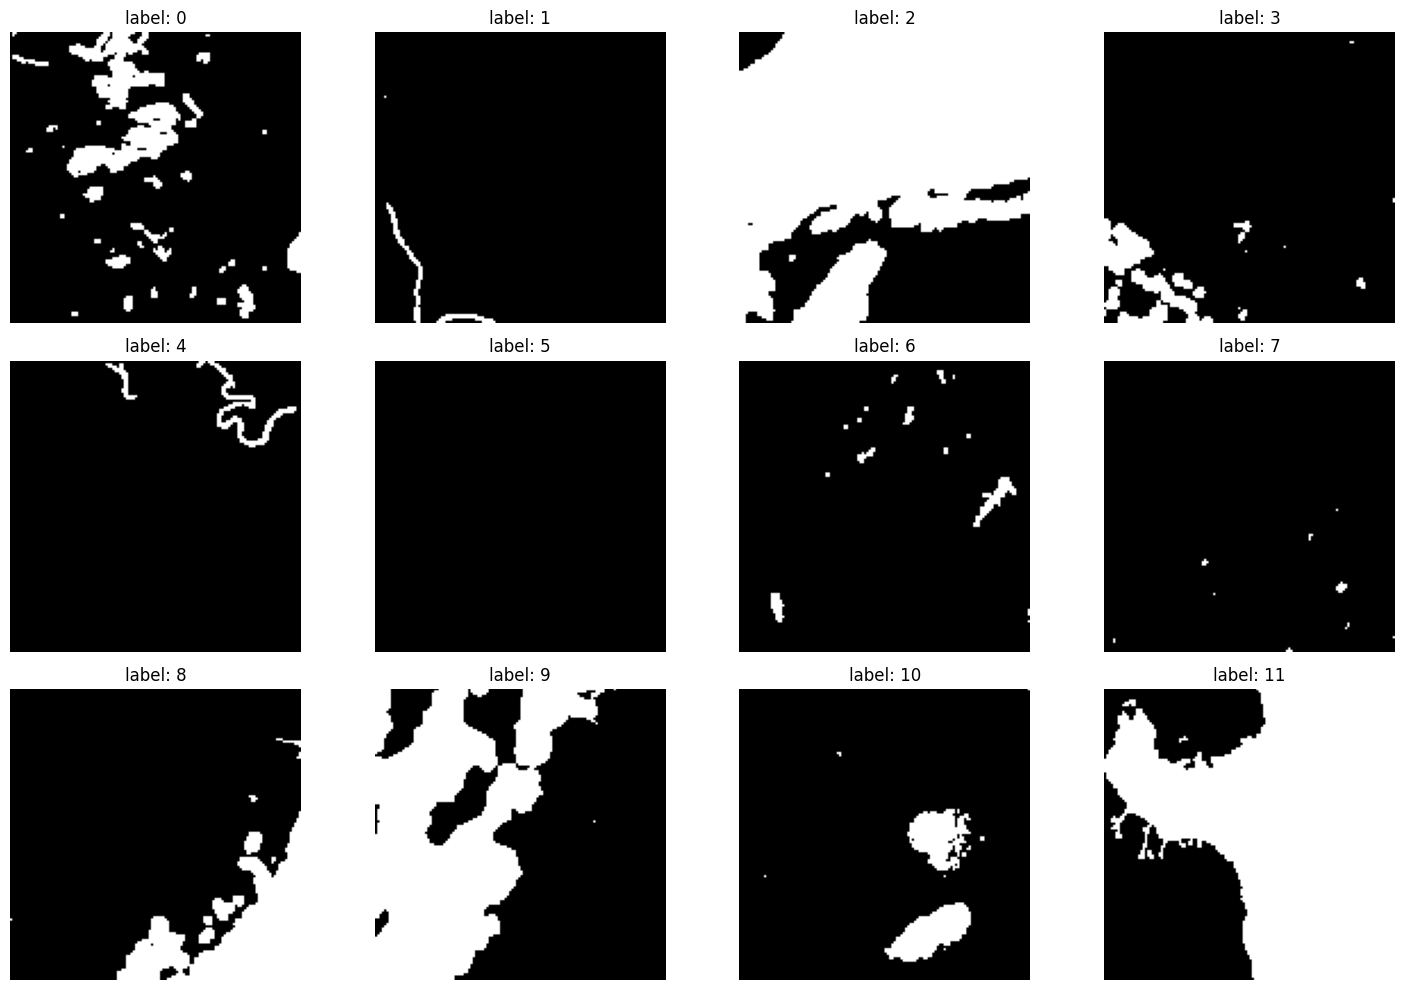

In [8]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))

for i in range(12):
    ax = axes[i // 4, i % 4]
    label = labels_ten[i]    
    label_np = label.squeeze().numpy()
    
    ax.imshow(label_np, cmap='gray')  
    ax.set_title(f"label: {i}")
    ax.axis('off')
    
plt.tight_layout()
plt.show()


In [9]:
img_train, img_val_test, label_train, label_val_test = train_test_split(
    images_ten, labels_ten, test_size=0.3, random_state=42
)

img_val, img_test, label_val, label_test = train_test_split(
    img_val_test, label_val_test, test_size=0.5, random_state=42
)

In [10]:
print(img_train.size())
print(img_val.size())
print(img_test.size())

torch.Size([214, 12, 128, 128])
torch.Size([46, 12, 128, 128])
torch.Size([46, 12, 128, 128])


In [11]:
train_dataset = TensorDataset(img_train, label_train)
val_dataset   = TensorDataset(img_val, label_val)
test_dataset  = TensorDataset(img_test, label_test)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(Conv → ReLU) × 2 with same padding"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv (with same padding)"""
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # Pad x1 if needed (just in case shape mismatch)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        if diffY != 0 or diffX != 0:
            x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                            diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    """Final 1×1 Conv Layer"""
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.in_conv = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.out_conv = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.in_conv(x)     # (B, 64, 128, 128)
        x2 = self.down1(x1)      # (B, 128, 64, 64)
        x3 = self.down2(x2)      # (B, 256, 32, 32)
        x4 = self.down3(x3)      # (B, 512, 16, 16)
        x5 = self.down4(x4)      # (B, 1024, 8, 8)
        
        x = self.up1(x5, x4)     # (B, 512, 16, 16)
        x = self.up2(x, x3)      # (B, 256, 32, 32)
        x = self.up3(x, x2)      # (B, 128, 64, 64)
        x = self.up4(x, x1)      # (B, 64, 128, 128)
        logits = self.out_conv(x)  # (B, 1, 128, 128)
        return logits


In [14]:
def plot_metrics(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.show()

In [15]:
def train_model(model, train_loader, val_loader, lr, epochs):
    LCE = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    best_val_acc = 0.0


    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, total = 0.0, 0, 0

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            output = model(x_batch)
            loss = LCE(output, y_batch)
            loss.backward()
            optimizer.step()

            predicted = torch.sigmoid(output) > 0.5
            train_correct += (predicted == y_batch.bool()).sum().item()
            train_loss += loss.item() * y_batch.numel() # is actually the mean loss per pixel, not per image.
                                                        # loss = 1/(32*128*128) * (pixel loss)
            total += y_batch.numel()

        train_loss /= total
        train_correct /= total
        train_losses.append(train_loss)
        train_accuracies.append(train_correct)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = LCE(outputs, labels)

                val_loss += loss.item() * y_batch.numel()
                predicted = torch.sigmoid(output) > 0.5
                val_correct += (predicted == y_batch.bool()).sum().item()

                val_total += y_batch.numel()

        val_losses.append(val_loss / val_total)
        val_accuracies.append(val_correct / val_total)
        if val_correct / val_total > best_val_acc:
            best_val_acc = val_correct / val_total
            torch.save(model.state_dict(), "/kaggle/working/best_model.pth")
        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    print("\n")
    return train_losses, val_losses, train_accuracies, val_accuracies


Epoch 1/32, Train Loss: 0.7180, Train Acc: 0.2427, Val Loss: 0.7118, Val Acc: 0.2373
Epoch 2/32, Train Loss: 0.7090, Train Acc: 0.2427, Val Loss: 0.7025, Val Acc: 0.2914
Epoch 3/32, Train Loss: 0.6961, Train Acc: 0.3049, Val Loss: 0.6858, Val Acc: 0.6054
Epoch 4/32, Train Loss: 0.6590, Train Acc: 0.7863, Val Loss: 0.5486, Val Acc: 0.8571
Epoch 5/32, Train Loss: 0.5504, Train Acc: 0.7576, Val Loss: 0.5350, Val Acc: 0.7966
Epoch 6/32, Train Loss: 0.4933, Train Acc: 0.7720, Val Loss: 0.4898, Val Acc: 0.7968
Epoch 7/32, Train Loss: 0.4626, Train Acc: 0.7738, Val Loss: 0.4566, Val Acc: 0.7614
Epoch 8/32, Train Loss: 0.4385, Train Acc: 0.7747, Val Loss: 0.4201, Val Acc: 0.7287
Epoch 9/32, Train Loss: 0.4181, Train Acc: 0.7778, Val Loss: 0.3922, Val Acc: 0.7837
Epoch 10/32, Train Loss: 0.3891, Train Acc: 0.8189, Val Loss: 0.3605, Val Acc: 0.8001
Epoch 11/32, Train Loss: 0.3630, Train Acc: 0.8576, Val Loss: 0.3355, Val Acc: 0.8352
Epoch 12/32, Train Loss: 0.3421, Train Acc: 0.8759, Val Loss: 0

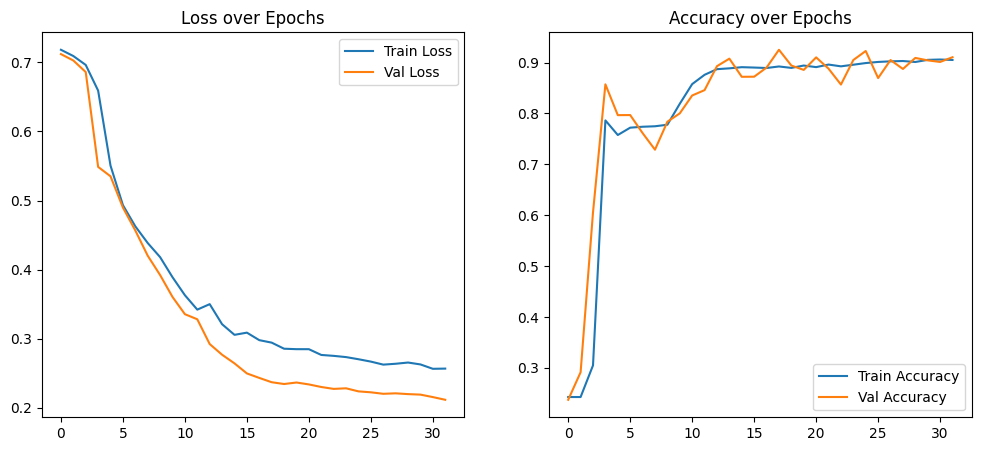

In [33]:
model = UNet(n_channels=12, n_classes=1).to(device)
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, 0.0001, epochs=32)
plot_metrics(train_loss, val_loss, train_acc, val_acc)

In [27]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels.bool()).sum().item()
            total += labels.numel()
    return correct / total


In [34]:
model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))

<All keys matched successfully>

In [35]:
test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8892
